In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc,precision_recall_curve,roc_curve,confusion_matrix
import os,sys
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
np.random.seed(10)
random.seed(10)


In [2]:
## DOESNT WORK og virker til at den giver alle peptides samme binding score, så der er en fejl somewhere

big_file = pd.read_csv("../data/semi_supervised_data_w_binding_no_overlap.csv",index_col=0)

# add parts column with zeros all the way 
n = big_file.shape[0]
empty_column = np.zeros((n))
big_file = big_file.assign(binding_score=empty_column)


# # binding_data = pd.read_csv(path_to_file,sep="\t",names=["peptide","HLA_allele", "Qualitative Measure", "binding_score"])
# # for i in range(binding_data.shape[0]):
# #     small_file_peptide = binding_data.loc[i, "peptide"]
# #     small_file_hla = binding_data.loc[i, "HLA_allele"]
# #     binding = binding_data.loc[i,"binding_score"]
# #     for j in range(big_file.shape[0]):
# #         peptide = big_file.loc[j,"peptide"]
# #         mhc = big_file.loc[j,"HLA_allele"]
# #         if peptide == small_file_peptide and mhc == small_file_hla:                
# #             big_file.iloc[j,"binding_score"] = binding
# #             break
  
# # #print(big_file.loc[133,"parts"])
big_file.to_csv("../data/semi_supervised_data_w_binding_no_overlap_astrid.csv")

## The Network

In [3]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d

import torch.optim as optim
from sklearn.metrics import accuracy_score,recall_score,f1_score

In [4]:
def compute_conv_dim(dim_size,kernel_size,padding,stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)
compute_conv_dim(34,2,0,1)

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight.data, 1)
          nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

In [5]:
# hyperameters of the model
# Peptide [batch_size, input_channels, input_height, input_width] > [batch_size, 1, 10, 12]
peptide_input_channels = 1
peptide_input_height = 10
peptide_input_width = 12

# Peptide [batch_size, input_channels, input_height, input_width] > [batch_size, 1, 34, 12]
hla_input_channels = 1
hla_input_height = 34
hla_input_width = 12

# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Convelution of peptide
        self.conv1_peptide = Conv2d(in_channels=peptide_input_channels,
                            out_channels=16,
                            kernel_size=(2,12),
                            stride=1,
                            padding=0)
        
        self.BatchNorm_conv1_peptides = BatchNorm2d(16,track_running_stats=False) # Output channels from the previous layer
        self.conv2_peptide = Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=(2,1),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv2_peptides = BatchNorm2d(32,track_running_stats=False) # Output channels from the previous layer
        self.maxpool1_peptide = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)

        # Convelution of HLA
        self.conv1_HLA = Conv2d(in_channels=peptide_input_channels,
                            out_channels=16,
                            kernel_size=(15,12),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv1_HLA = BatchNorm2d(16,track_running_stats=False) # Output channels from the previous layer
        self.maxpool1_HLA = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)
        
        self.conv2_HLA = Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=(9,1),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv2_HLA = BatchNorm2d(32,track_running_stats=False) # Output channels from the previous layer
        self.maxpool2_HLA = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)

        # # Denselayer
        # self.L_in = Linear(in_features=160,
        #                     out_features=128)
        
        # self.drop_out = nn.Dropout(p=0.2)
        self.L_out = Linear(in_features=160,
                            out_features=2,
                            bias=False)


    def forward(self, peptide, HLA): # x.size() = [batch, channel, height, width]

        # Encoding the peptide
        peptide = self.conv1_peptide(peptide)
        # peptide = self.BatchNorm_conv1_peptides(peptide)
        peptide = relu(peptide)
        peptide = self.conv2_peptide(peptide)
        peptide = self.BatchNorm_conv2_peptides(peptide)
        peptide = relu(peptide)
        peptide = self.maxpool1_peptide(peptide)
        peptide = torch.flatten(peptide,start_dim=1)

        # Encoding the HLA
        HLA = self.conv1_HLA(HLA)
        # HLA = self.BatchNorm_conv1_HLA(HLA)
        HLA = relu(HLA)
        HLA = self.maxpool1_HLA(HLA)
        HLA = self.conv2_HLA(HLA)
        HLA = self.BatchNorm_conv2_HLA(HLA)
        HLA = relu(HLA)
        HLA = self.maxpool2_HLA(HLA)
        HLA = torch.flatten(HLA,start_dim=1)

        # Combining the output
        
        combined_input = torch.cat((peptide, HLA), 1)
        # x = self.L_in(combined_input)
        # x = self.drop_out(x)
        # x = relu(x)
        x = self.L_out(combined_input)
        x = nn.ReLU()(x)
        return softmax(x, dim=1)

net = Net()
print(net)
net.apply(initialize_weights)
print(net)

Net(
  (conv1_peptide): Conv2d(1, 16, kernel_size=(2, 12), stride=(1, 1))
  (BatchNorm_conv1_peptides): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2_peptide): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1))
  (BatchNorm_conv2_peptides): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (maxpool1_peptide): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv1_HLA): Conv2d(1, 16, kernel_size=(15, 12), stride=(1, 1))
  (BatchNorm_conv1_HLA): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (maxpool1_HLA): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2_HLA): Conv2d(16, 32, kernel_size=(9, 1), stride=(1, 1))
  (BatchNorm_conv2_HLA): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (maxpool2_HLA): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation

In [6]:
peptide_random = np.random.normal(0,1, (10, 1, 10, 12)).astype('float32')
peptide_random = Variable(torch.from_numpy(peptide_random))
HLA_random = np.random.normal(0,1, (10, 1, 34, 12)).astype('float32')
HLA_random = Variable(torch.from_numpy(HLA_random))
binding_random = np.random.normal(0,1, (10, 1)).astype('float32')
binding_random = Variable(torch.from_numpy(binding_random))

output = net(peptide_random,HLA_random)
output

tensor([[0.7506, 0.2494],
        [0.9803, 0.0197],
        [0.5000, 0.5000],
        [0.9019, 0.0981],
        [0.5809, 0.4191],
        [0.8706, 0.1294],
        [0.8723, 0.1277],
        [0.8535, 0.1465],
        [0.8694, 0.1306],
        [0.7621, 0.2379]], grad_fn=<SoftmaxBackward0>)

## Functions for loading data

In [7]:

def encode_peptide_aaindex(aa_seq,aaindex_PCA,row):
    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(PCs)]))
        else:
            try:
                encoded_aa_seq.append(aaindex_PCA.loc[aa].to_numpy())
            except KeyError:
                print(row)
                sys.exit(1)
    return np.array(encoded_aa_seq)

def encode_dataset(df,aaindex_PCA,HLA_dict,peptide_len,padding="right",testing=False):
    encoded_peptides = []
    encoded_labels = []
    encoded_hlas = []
    encoded_binding_scores = []
    for i,row in df.iterrows():
        peptide = row["peptide"]
        HLA = HLA_dict[row["HLA_allele"].replace(":","")]
        encoded_peptide = encode_peptide_aaindex(peptide,aaindex_PCA,row)
        
        # Adding padding
        if len(encoded_peptide) < peptide_len:
            n_added = peptide_len-len(encoded_peptide)
            if padding == "right":
                encoded_peptide = np.pad(encoded_peptide, ((0, 1), (0, 0)), 'constant')
            elif padding == "left":
                encoded_peptide = np.pad(encoded_peptide, ((1, 0), (0, 0)), 'constant')
            elif padding == "random":
                top_pad = random.choice([0,1])
                bot_pad = 1-top_pad
                encoded_peptide = np.pad(encoded_peptide, ((top_pad, bot_pad), (0, 0)), 'constant')


        encoded_HLA = encode_peptide_aaindex(HLA,aaindex_PCA,row)
        # Add encoded datat to dataframe
        encoded_peptides.append(encoded_peptide)
        encoded_hlas.append(encoded_HLA)



        if testing is False:
            encoded_label = min(1,row["positive_subjects"])
            encoded_labels.append(encoded_label)
            binding_score = row['binding_score']
            encoded_binding_scores.append(binding_score)

    
    encoded_peptides = np.array(encoded_peptides).astype('float32')
    encoded_hlas = np.array(encoded_hlas).astype('float32')
    if testing is False:
        encoded_labels = np.array(encoded_labels).astype('float32')
        encoded_binding_scores = np.array(encoded_binding_scores).astype('float32')

    return encoded_peptides, encoded_hlas, encoded_binding_scores, encoded_labels


## Functions for training the models

In [19]:
def append_artificial_data_to_train(dataloader,add_0,add_1):
    train_data = []
    for batch in dataloader:
        train_data += batch.numpy().tolist()
    train_data = np.array(train_data)
    return np.concatenate((train_data,add_0.numpy(),add_1.numpy()),axis=0)


def plot_learning_curve(train_accuracies,val_accuracies):
    epoch = np.arange(len(train_accuracies))
    plt.figure()
    plt.plot(epoch, train_accuracies, 'r', epoch, val_accuracies, 'b')
    plt.legend(['Train Accucary','Validation Accuracy'])
    plt.xlabel('epochs'), plt.ylabel('Acc')



def validation(model,device,valid_loaders,train_loaders):
    peptide_val_loader,HLA_val_loader,label_val_loader,binding_score_val_loader = valid_loaders
    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    model.eval()
    with torch.no_grad():
        all_train_targets = []
        all_predicted_train_labels = []
        for i in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[i]
            train_HLA = HLA_train_loader[i]
            train_labels = label_train_loader[i].long()
            train_binding_scores = binding_score_train_loader[i]
            outputs = model(train_peptides,train_HLA) #,train_binding_scores
            _,predicted_labels =  torch.max(outputs, 1)

            all_predicted_train_labels += predicted_labels.numpy().tolist()
            all_train_targets += train_labels.numpy().tolist()
        
        all_val_targets = []
        all_predicted_val_labels = []
        all_probabilities_val = []
        for j in range(len((peptide_val_loader))):
            val_peptides = peptide_val_loader[j]
            val_HLA = HLA_val_loader[j]
            val_labels = label_val_loader[j].long()
            val_binding_scores = binding_score_val_loader[j]
            outputs = model(val_peptides,val_HLA) #,val_binding_scores
            probability,predicted_labels =  torch.max(outputs, 1)
            all_predicted_val_labels += predicted_labels.numpy().tolist()
            all_val_targets += val_labels.numpy().tolist()
            all_probabilities_val += probability.numpy().tolist()

    return all_train_targets,all_predicted_train_labels,all_val_targets,all_predicted_val_labels,all_probabilities_val


def train(model, device, epochs, train_loaders, valid_loaders, confidence_threshold):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-4)

    # Early stopping
    the_last_loss = 100
    patience = 500
    trigger_times = 0
    
    all_val_targets_pr_epoch = []
    all_val_predictions_pr_epoch = []
    all_val_probabilities_pr_epoch = []
    losses = []

    train_accuracies = []
    val_accuracies = []

    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    
    peptide_artificial_loader = peptide_train_loader.copy()
    HLA_artificial_loader = HLA_train_loader.copy()
    label_artificial_loader = label_train_loader.copy()


    for epoch in range(epochs):
        model.train()
        current_loss = 0
        for train_batch_index in range(len((peptide_artificial_loader))):
            train_peptides = peptide_artificial_loader[train_batch_index]
            train_HLA = HLA_artificial_loader[train_batch_index]
            train_labels = label_artificial_loader[train_batch_index].long()
            # train_binding_scores = binding_score_train_loader[train_batch_index]

            # zero the parameter gradients
            optimizer.zero_grad()
            try:
                outputs = model(train_peptides,train_HLA)  #,train_binding_scores
                loss = criterion(outputs, train_labels)
                loss.backward()
                optimizer.step()
                current_loss += loss.item()

            except Exception:
                print(train_peptides)
                print(train_HLA)
                print(train_peptides.shape)
                print(train_HLA.shape)
                sys.exit(1)
                
            
        losses.append(current_loss/len((peptide_train_loader)))

        all_train_targets,all_predicted_train_labels,all_val_targets,all_predicted_val_labels,all_probabilities_val = validation(model,device,valid_loaders,train_loaders)
    
        # Calculating the accuracies
        train_accuracies.append(accuracy_score(all_train_targets,all_predicted_train_labels))
        val_accuracies.append(accuracy_score(all_val_targets,all_predicted_val_labels))
        # Saving the predicitons for further validation
        all_val_targets_pr_epoch.append(all_val_targets)
        all_val_predictions_pr_epoch.append(all_predicted_val_labels)
        all_val_probabilities_pr_epoch.append(all_probabilities_val)

        #if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (epoch+1, losses[-1], train_accuracies[-1], val_accuracies[-1]))
        

        # Early stopping
        the_current_loss = val_accuracies[-1]
        the_last_loss = 0 if len(val_accuracies) < 2 else val_accuracies[-2]

        # print('The current valdiation loss:', the_current_loss)

        if the_current_loss < the_last_loss:
            trigger_times += 1
            # print('trigger times:', trigger_times)

            if trigger_times >= patience:
                # print('Early stopping at epoch',epoch)
                return model,train_accuracies,val_accuracies,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_val_probabilities_pr_epoch

        else:
            # print('trigger times: 0')
            trigger_times = 0


        if epoch % 30 == 0 and epoch > 0:
            ...
        
            peptide_semisup = semisup_peptides_encoded.reshape(-1,1,10,12)
            HLA_semisup = semisup_HLA_encoded.reshape(-1,1,34,12)

            peptide_semisup_loader = list(DataLoader(peptide_semisup,batch_size=len(peptide_semisup)))
            HLA_semisup_loader = list(DataLoader(HLA_semisup,batch_size=len(peptide_semisup)))

            model.eval()

            semisup_outputs = model(peptide_semisup_loader[0],HLA_semisup_loader[0])
            probability,predicted_labels =  torch.max(semisup_outputs, 1)
            
            predicted_0_above_threshold_indx = np.where((probability > confidence_threshold) & (predicted_labels == 0))
            predicted_1_above_threshold_indx = np.where((probability > confidence_threshold) & (predicted_labels == 1))
            
            print("## Possible options to select 1:", + len(predicted_1_above_threshold_indx[0]))
            print("## Possible options to select 0:",len(predicted_0_above_threshold_indx[0]))

            # Number added

            chosen_500_label_0 = np.random.choice(predicted_0_above_threshold_indx[0], 500)
            chosen_500_label_1 = np.random.choice(predicted_1_above_threshold_indx[0], 500)
        
            chosen_peptides_0 = peptide_semisup_loader[0][chosen_500_label_0]
            chosen_HLA_0 =  HLA_semisup_loader[0][chosen_500_label_0]

            chosen_peptides_1 = peptide_semisup_loader[0][chosen_500_label_1]
            chosen_HLA_1 =  HLA_semisup_loader[0][chosen_500_label_1]

            artifical_peptides = append_artificial_data_to_train(peptide_train_loader,chosen_peptides_0,chosen_peptides_1)
            artifical_HLA = append_artificial_data_to_train(HLA_train_loader,chosen_HLA_0,chosen_HLA_1)
            artifical_labels = append_artificial_data_to_train(label_train_loader,torch.from_numpy(np.array([0] * 1000)),torch.from_numpy(np.array([1] * 1000)))

            shuffle_idx = random.sample([i for i in range(len(artifical_peptides))], len(artifical_peptides))

            artifical_peptides = artifical_peptides[shuffle_idx].astype('float32')
            artifical_HLA = artifical_HLA[shuffle_idx].astype('float32')
            artifical_labels = artifical_labels[shuffle_idx].astype('float32')

            peptide_artificial_loader = list(DataLoader(artifical_peptides,batch_size=batch_size))
            HLA_artificial_loader = list(DataLoader(artifical_HLA,batch_size=batch_size))
            label_artificial_loader = list(DataLoader(artifical_labels,batch_size=batch_size))
            print("New data was added !!")

    # model.train() #make sure model is in training mode when it leaves this function

    return model,train_accuracies,val_accuracies,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_val_probabilities_pr_epoch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)




Device state: cpu


## Encoding entire data set

In [20]:
# Loading the databases
aaindex_PCA = pd.read_csv('../data/PCA_repr_aa.csv',index_col=0)
hla_database = pd.read_csv('../data/formatted_hla2paratope_MHC_pseudo.dat', sep=' ',index_col=0)
hla_dic = hla_database.to_dict("dict")["pseudo"]

all_data = pd.read_csv("../data/filtered_data_IEDB_4_tested_len_9_10_full_HLA_Multi_assay_w_binding_w_parts.csv")
all_data = all_data.sample(frac=1, random_state=1).reset_index(drop=True)

print("##Encoding all")
all_peptides_encoded,all_HLA_encoded,all_binding_scores_encoded,all_label_encoded = encode_dataset(all_data,aaindex_PCA,hla_dic,peptide_len=10,padding="right")
print("##Encoding semi-supervised")
semisup_data = pd.read_csv("../data/semi_supervised_data_w_binding_no_overlap_astrid.csv")
semisup_data = semisup_data.sample(frac=1, random_state=1).reset_index(drop=True)

semisup_peptides_encoded, semisup_HLA_encoded,semisup_binding_scores_encoded,_ = encode_dataset(semisup_data,aaindex_PCA,hla_dic,peptide_len=10,padding="right",testing=True)

##Encoding all
##Encoding semi-supervised


## 5-fold cross-validation loop

In [21]:
N = len(all_data)
K = 1
no_epoch = 250

testing = False
part_dict = {0:[0,1], 1:[2,3], 2:[4,5], 3:[6,7], 4:[8,9]}
part_dict_testing = {0:[1,2], 1:[3,4], 2:[5,6], 3:[7,8], 4:[9]}
partitions = [0,1,2,3,4,5,6,7,8,9]

batch_size = 100

lst_train_accuracies = []

lst_val_accuracies = []
lst_val_predictions = []
lst_val_labels = []
lst_val_probabilities = []

lst_test_accuracies = []
lst_test_predictions = []
lst_test_labels = []
lst_test_probabilities = []

for i in range(K):
    if testing == True:
        ## The partitions to use for training, validation ##
        testing_parts = [0]
        validation_parts = part_dict_testing[i]
        training_parts = [j for j in range(1,10) if j not in validation_parts]
        print("the val and train parts")
        print(validation_parts, training_parts)

        test_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(testing_parts)]
        test_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(testing_parts)]
        test_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(testing_parts)]
        test_label_encoded = all_label_encoded[all_data["parts"].isin(testing_parts)]

        peptide_test = test_peptides_encoded.reshape(-1,1,10,12)
        HLA_test = test_HLA_encoded.reshape(-1,1,34,12) # 46 aligned representataion and 34 if not aligned
        binding_test = test_binding_scores_encoded.reshape(-1,1)
        label_test = test_label_encoded.reshape(-1)

        peptide_test_loader = list(DataLoader(peptide_test,batch_size=len(peptide_test)))
        HLA_test_loader = list(DataLoader(HLA_test,batch_size=len(peptide_test)))
        label_test_loader = list(DataLoader(label_test,batch_size=len(peptide_test)))
        binding_score_test_loader = list(DataLoader(binding_test,batch_size=len(peptide_test)))

    else:

        ## The partitions to use for training, validation ##
        validation_parts = part_dict[i]
        training_parts = [j for j in range(10) if j not in validation_parts]
        print("the val and train parts")
        print(validation_parts, training_parts)

    train_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(training_parts)]
    train_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(training_parts)]
    train_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(training_parts)]
    train_label_encoded = all_label_encoded[all_data["parts"].isin(training_parts)]

    val_peptides_encoded = all_peptides_encoded[all_data["parts"].isin(validation_parts)]
    val_HLA_encoded = all_HLA_encoded[all_data["parts"].isin(validation_parts)]
    val_binding_scores_encoded = all_binding_scores_encoded[all_data["parts"].isin(validation_parts)]
    val_label_encoded = all_label_encoded[all_data["parts"].isin(validation_parts)]

    ## Reshaping everything ##
    peptide_train = train_peptides_encoded.reshape(-1,1,10,12)
    HLA_train = train_HLA_encoded.reshape(-1,1,34,12)
    binding_train = train_binding_scores_encoded.reshape(-1,1)
    label_train = train_label_encoded.reshape(-1)

    peptide_val = val_peptides_encoded.reshape(-1,1,10,12)
    HLA_val = val_HLA_encoded.reshape(-1,1,34,12) # 46 aligned representataion and 34 if not aligned
    binding_val = val_binding_scores_encoded.reshape(-1,1)
    label_val = val_label_encoded.reshape(-1)
    

    ## Batches for training the model ##
    peptide_train_loader = list(DataLoader(peptide_train,batch_size=batch_size))
    HLA_train_loader = list(DataLoader(HLA_train,batch_size=batch_size))
    label_train_loader = list(DataLoader(label_train,batch_size=batch_size))
    binding_score_train_loader = list(DataLoader(binding_train,batch_size=batch_size))

    peptide_val_loader = list(DataLoader(peptide_val,batch_size=batch_size))
    HLA_val_loader = list(DataLoader(HLA_val,batch_size=batch_size))
    label_val_loader = list(DataLoader(label_val,batch_size=batch_size))
    binding_score_val_loader = list(DataLoader(binding_val,batch_size=batch_size))

    train_loaders = (peptide_train_loader, HLA_train_loader, label_train_loader, binding_score_train_loader)
    val_loaders = (peptide_val_loader, HLA_val_loader, label_val_loader, binding_score_val_loader)

    net = Net()
    net.apply(initialize_weights)

    trained_model,train_accuracies,val_accuracies,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_val_probabilities_pr_epoch= train(net,device,no_epoch,train_loaders,val_loaders, 0.8)
    lst_train_accuracies.append(train_accuracies)
    lst_val_accuracies.append(val_accuracies)
    lst_val_predictions.append(np.array(all_val_predictions_pr_epoch))
    lst_val_labels.append(np.array(all_val_targets_pr_epoch))
    lst_val_probabilities.append(np.array(all_val_probabilities_pr_epoch))
    
    if testing == True:
        
        trained_model.eval()
        test_outputs = trained_model(peptide_test_loader[0],HLA_test_loader[0],binding_score_test_loader[0])
        probability,predicted_labels =  torch.max(test_outputs, 1)
        test_accuracies = accuracy_score(label_test,predicted_labels)
        
        lst_test_accuracies.append(test_accuracies)
        lst_test_predictions.append(predicted_labels)
        lst_test_labels.append(label_test)
        lst_test_probabilities.append(probability)



the val and train parts
[0, 1] [2, 3, 4, 5, 6, 7, 8, 9]
Epoch  1 : Train Loss 0.672652 , Train acc 0.561989, Valid acc 0.579421
Epoch  2 : Train Loss 0.641323 , Train acc 0.618417, Valid acc 0.634084
Epoch  3 : Train Loss 0.620807 , Train acc 0.655545, Valid acc 0.663023
Epoch  4 : Train Loss 0.608023 , Train acc 0.666830, Valid acc 0.666238
Epoch  5 : Train Loss 0.600208 , Train acc 0.677134, Valid acc 0.675884
Epoch  6 : Train Loss 0.595434 , Train acc 0.679751, Valid acc 0.682958
Epoch  7 : Train Loss 0.592147 , Train acc 0.682695, Valid acc 0.682958
Epoch  8 : Train Loss 0.589677 , Train acc 0.685640, Valid acc 0.683601
Epoch  9 : Train Loss 0.587564 , Train acc 0.687602, Valid acc 0.685531
Epoch 10 : Train Loss 0.585722 , Train acc 0.688911, Valid acc 0.686174
Epoch 11 : Train Loss 0.584046 , Train acc 0.690056, Valid acc 0.688103
Epoch 12 : Train Loss 0.582548 , Train acc 0.690383, Valid acc 0.690032
Epoch 13 : Train Loss 0.581181 , Train acc 0.692836, Valid acc 0.691318
Epoch 14

## Functions for "statistics"

In [22]:
def plot_epochs(K, lst_train_acc, lst_val_acc): 
    plt.figure()
    for i in range(K):
        epoch = np.arange(len(lst_train_acc[i]))
        plt.plot(epoch, lst_train_acc[i], 'r', epoch, lst_val_acc[i], 'b')
    plt.title("Performance of {} fold CV".format(K))
    plt.legend(['Train Accuracy','Validation Accuracy'])
    plt.xlabel('epochs'), plt.ylabel('Acc')
    plt.show        

#plt.savefig("../plots/FFNN_3_layers_bigthensmall_btchnrm_drpt_bndscr.png", dpi = 400, transparent = False)

In [23]:
def calculate_avg_val_performance(K, N, lst_val_acc, lst_val_lab, lst_val_pred):
    """Calculate the generalization error

    Args:
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
        N (int): Total number of observations in data set
    """
    avg_recall = 0
    avg_accuracy = 0 
    avg_f1 = 0

    res = np.zeros((K,5))
    for i in range(K):
        best_epoch_model = np.argmax(lst_val_acc[i])
        n = len(lst_val_lab[i][best_epoch_model])
        accuracy = accuracy_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        recall = recall_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        f1 = f1_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        print(recall,accuracy,f1)

        res[i][0] = best_epoch_model
        res[i][1] = n
        res[i][2] = accuracy
        res[i][3] = recall
        res[i][4] = f1

        avg_recall += (n/N) * recall
        avg_accuracy += (n/N) * accuracy
        avg_f1 += (n/N) * f1

    print(f"Best average results - Recall: {avg_recall} accuracy: {avg_accuracy} f1-score: {avg_f1}")
    return res

In [24]:
def k_fold_confusion_matrix(K, lst_val_acc, lst_val_lab, lst_val_pred):
    """Plot the overall confusion matrix for 5 fold CV

    Args:
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
    """
    all_labels = []
    all_predictions = []
    for i in range(K):
        best_epoch_model = np.argmax(lst_val_acc[i])
        all_labels.extend(lst_val_lab[i][best_epoch_model])
        all_predictions.extend(lst_val_pred[i][best_epoch_model])

    fig = plt.figure(figsize=(10,6))
    plt.title("Confusion matrix of best epoch for validation performance")
    conf_mat = confusion_matrix(all_labels,all_predictions)
    sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [25]:
def violin_best_fold(res_mtrx, lst_val_acc, lst_val_lab, lst_val_pred, lst_val_prob):
    """For the best fold, find the best epoch, and plot the violin plot

    Args:
        res_mtrx (matrix): result matrix from calculate_avg_performance
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
        lst_val_prob (list of lists): list of lists containing validation probabilities for each fold
    """
    best_fold = np.argmax(res_mtrx[:,2])
    best_epoch_model = np.argmax(lst_val_acc[best_fold])
    labels_best_epoch = lst_val_lab[best_fold][best_epoch_model]
    predictions_best_epoch = lst_val_pred[best_fold][best_epoch_model]
    probabilities_best_epoch = lst_val_prob[best_fold][best_epoch_model]
    true_predictions = [x==y for x,y in zip(labels_best_epoch,predictions_best_epoch)]
    dataframe = pd.DataFrame()
    dataframe["Probs"] = probabilities_best_epoch
    dataframe["Predictions"] = predictions_best_epoch
    dataframe["Labels"] = labels_best_epoch
    dataframe["True"] = true_predictions    

    plt.figure(figsize=(10,6))
    ax = sns.violinplot(x="True", y="Probs", data=dataframe)
    plt.title("For the best epoch of the best fold - so only one model here!")
    plt.xlabel("Predicted label")
    plt.ylabel("Probability associated with label")
    plt.show()

    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x="True", y="Probs", data=dataframe)
    plt.title("For the best epoch of the best fold - so only one model here!")
    plt.xlabel("Predicted label")
    plt.ylabel("Probability associated with label")
    plt.show()

## Statistics for network

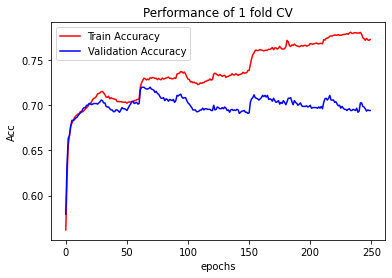

In [26]:
# line plot
plot_epochs(K, lst_train_accuracies, lst_val_accuracies)

In [27]:
# average validation recall, accuracy and f1 for the best epoch of each fold
N = len(all_data)

if testing == True:     # The data in testing has not been used, so reduce N
    N -= len(lst_test_labels[0])

result_mtrx = calculate_avg_val_performance(K, N, lst_val_accuracies, lst_val_labels, lst_val_predictions)


0.6792698826597132 0.7196141479099678 0.7050067658998647
Best average results - Recall: 0.13773173393347946 accuracy: 0.1459121137045247 f1-score: 0.14295025700538394


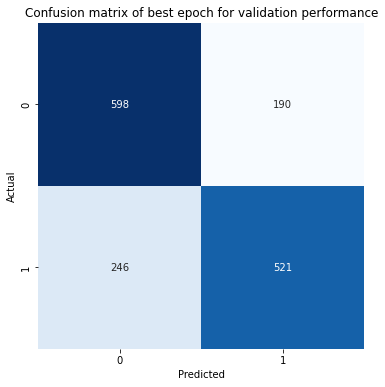

In [29]:
# Confusion matrix for all folds (if testing == true, part 0 is not included here!)
k_fold_confusion_matrix(K, lst_val_accuracies, lst_val_labels, lst_val_predictions)


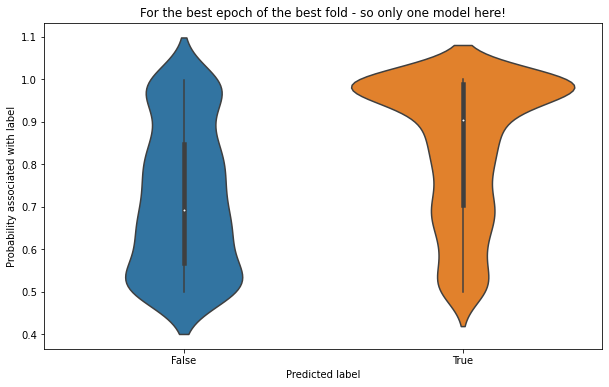

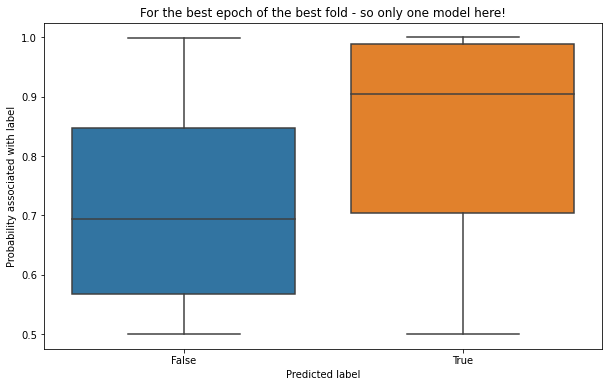

In [30]:
# violin plot
violin_best_fold(result_mtrx, lst_val_accuracies, lst_val_labels, lst_val_predictions, lst_val_probabilities)